In [1]:
import math
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
import pandas as pd
import seaborn as sns

# from lib.ml_utilities import


# User to fill in
RESULTS_FILE = 'l_66_4hps.csv'
NO_NOISE = False
ADDITIONAL_ARGS = {
     # '--max_size': 'MAX_SIZE',
    '--lamb': 'LAMBDA',
    '--temperature': 'NOISE_TEMPERATURE',
    '--h_lr': 'h_LR',
    '--h_null': 'h_NULL',
}

parameters ={
    'l_66_4hps.csv':
		{'vmin_n': 1., 'vmax_n': 3.5, 'vmin_t': 0., 'vmax_t': 0.6,
         'count': 7, 'count_none': 1_000},
    'l_66none_4hps.csv':
        {'vmin_n': 5., 'vmax_n': 10., 'vmin_t': 0., 'vmax_t': 0.25,
         'count': 7, 'count_none': 1},
}
parameters = parameters[RESULTS_FILE]

results_path = RESULTS_FILE
# results_path = os.path.join('collated_results', 'imle_logistic', RESULTS_FILE)
# results_path = os.path.join('..', 'results', RESULTS_FILE)
results = pd.read_csv(results_path, index_col=False)

hp = list(ADDITIONAL_ARGS.values())
grouped_by_hp = results.groupby(hp)

##  Analyse results for plot and table

In [2]:
means = grouped_by_hp.mean().drop(['j', 'dag'], axis='columns')
stds = grouped_by_hp.std().drop(['j', 'dag'], axis='columns')
stds = stds.rename({
    column: column + '_std' for column in results.columns}, axis=1)
means_std  = pd.concat((means, stds), axis=1)
means_std

nshd_c     tpr_c       size  \
LAMBDA NOISE_TEMPERATURE h_LR   h_NULL                                  
0.1    0.01              0.0001 0.000   1.816671  0.468771  51.166667   
                                0.001   1.908338  0.434592  50.916667   
                                0.010   2.115279  0.383158  53.250000   
                                0.100   2.922221  0.177071  55.625000   
                                1.000   3.443058  0.060008  56.833333   
...                                          ...       ...        ...   
100.0  10.00             0.1000 0.000   1.919450  0.418267  51.625000   
                                0.001   1.893046  0.431938  51.666667   
                                0.010   1.897225  0.433267  51.375000   
                                0.100   1.915279  0.423996  51.583333   
                                1.000   1.913883  0.425946  51.750000   

                                        nshd_c_std  tpr_c_std  size_std  
LAMBDA NOISE_TEMPERATURE h_LR   h_NULL                                   
0.1    0.01              0.0001 0.000     0.510843   0.118954  3.292504  
                                0.001     0.357555   0.076165  3.034822  
                                0.010     0.383093   0.078386  3.614584  
                                0.100     0.292686   0.060542  2.081231  
                                1.000     0.248951   0.028679  2.239306  
...                                            ...        ...       ...  
100.0  10.00             0.1000 0.000     0.666078   0.155355  3.104170  
                                0.001     0.684691   0.158043  2.914233  
                                0.010     0.675726   0.159391  3.145908  
                                0.100     0.669047   0.159433  2.857738  
                                1.000     0.669768   0.150824  2.862805  

[320 rows x 6 columns]

In [3]:
total = wrong = 0
for lamb in [0.1, 1, 10, 100]:
    for temp in [0.01, 0.1, 1, 10]:
        for h_null in [0, 1e-3, 1e-2, 1e-1, 1]:
            for h_lr in [1e-4, 1e-3, 1e-2, 1e-1]:
                count = results.loc[(results['LAMBDA']==lamb) &
                                    (results['NOISE_TEMPERATURE']==temp) &
			                        (results['h_NULL']==h_null) &
                                    (results['h_LR']==h_lr)].shape[0]
                total += 1
                if count != 24:
                    print((lamb, temp, h_null, h_lr), count)
                    wrong += 1
print(wrong, total)

0 320


## For lambda etc

In [4]:
(means_std.reset_index()['nshd_c'].min(),
    means_std.reset_index()['nshd_c'].max())

(1.4749999999999999, 3.443058333333333)

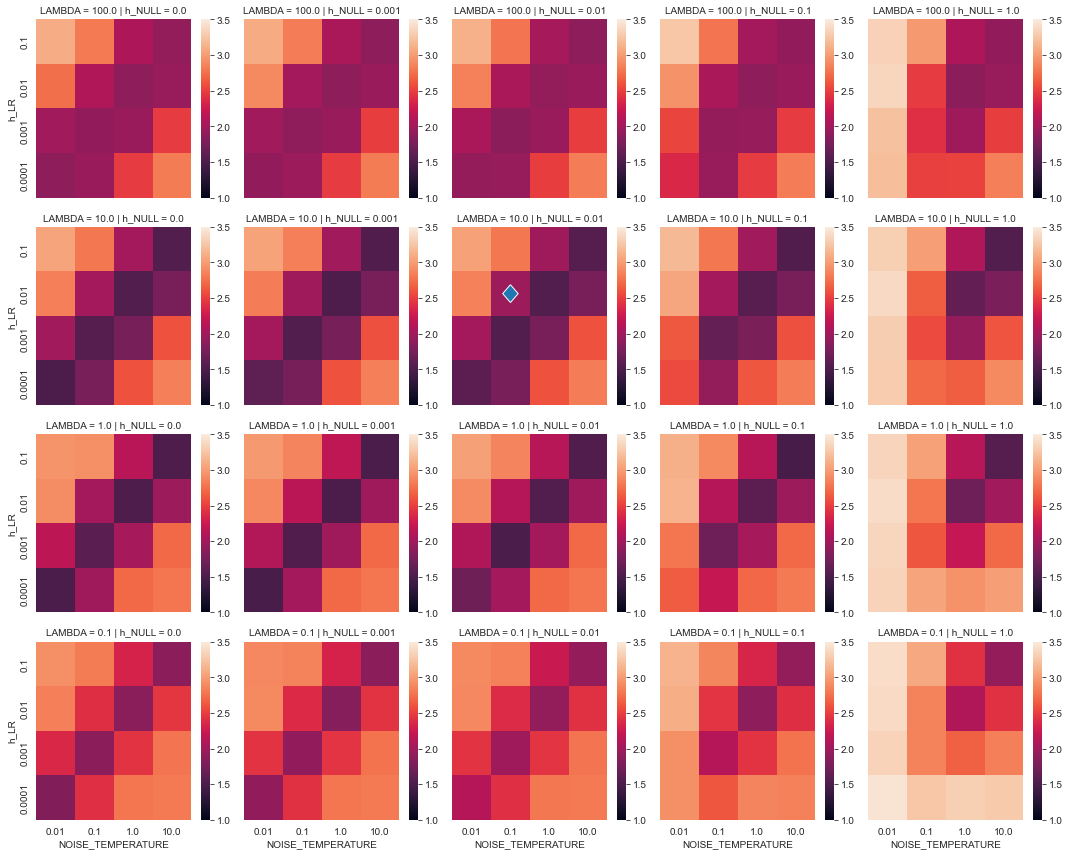

In [5]:
count = 0

# thanks to Q+A in https://stackoverflow
# .com/questions/41471238/how-to-make-heatmap-square-in-seaborn-facetgrid\n",
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    d.sort_index(level=0, ascending=False, inplace=True)
    h = sns.heatmap(d, **kwargs)
    global count
    if count == parameters['count']:
        circ = RegularPolygon((1.5, 1.5), 4, radius=.2)
        h.add_patch(circ)
    if count == parameters['count_none']:
        circ = Circle((1.5, 1.5), .2)
        h.add_patch(circ)
    count += 1
    return h

if NO_NOISE:
    draw_heatmap('h_LR', 'LAMBDA', 'nshd_c', data=means_std.reset_index(),
        vmin=1.5, vmax=4, square=True)
else:
    row_order = [100., 10., 1., 0.1]
    g = sns.FacetGrid(
        means_std.reset_index(), row='LAMBDA', col='h_NULL',
        row_order=row_order)
    g.map_dataframe(draw_heatmap, 'NOISE_TEMPERATURE', 'h_LR', 'nshd_c',
        vmin=parameters['vmin_n'], vmax=parameters['vmax_n'])


In [6]:
means_std.reset_index()['tpr_c'].max()

0.5628875

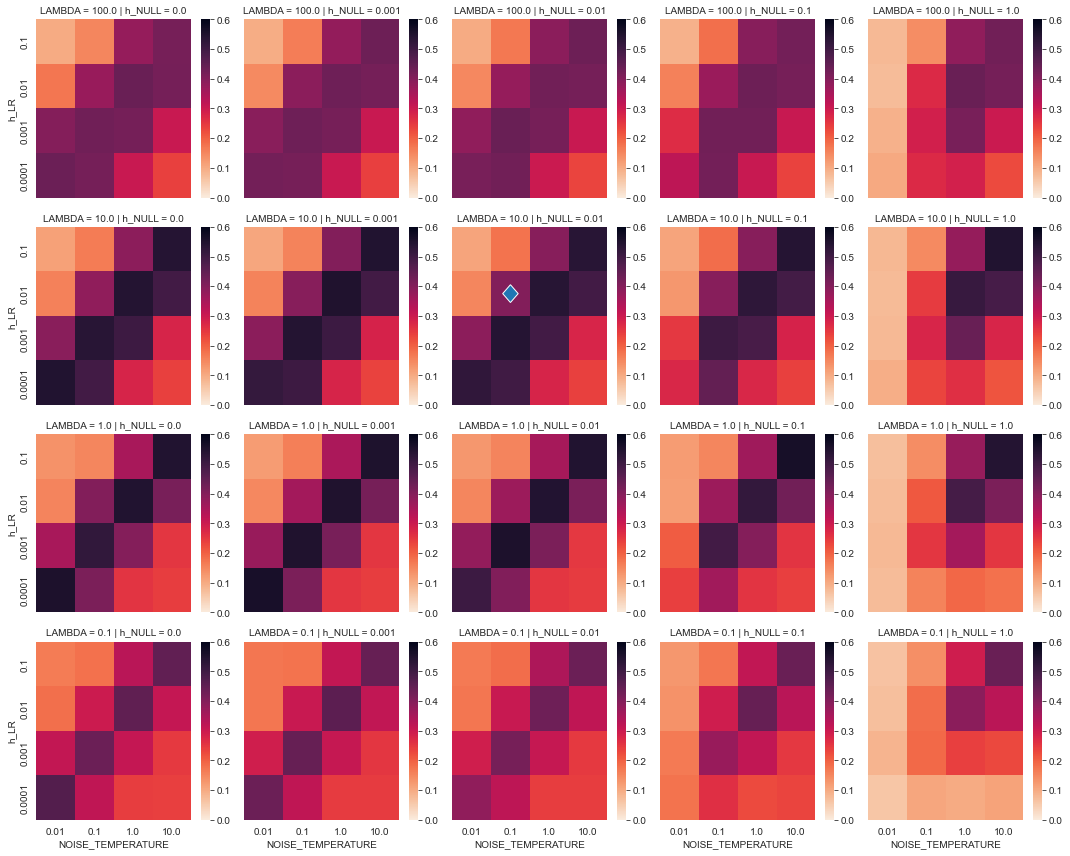

In [7]:
count = 0

def draw_heatmap_r(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    d.sort_index(level=0, ascending=False, inplace=True)
    h = sns.heatmap(d, **kwargs, cmap='rocket_r')
    global count
    if count == parameters['count']:
        circ = RegularPolygon((1.5, 1.5), 4, radius=.2)
        h.add_patch(circ)
    if count == parameters['count_none']:
        circ = Circle((1.5, 1.5), .2)
        h.add_patch(circ)
    count += 1
    return h

if NO_NOISE:
    draw_heatmap_r('h_LR', 'LAMBDA', 'tpr_c', data=means_std.reset_index(),
        vmin=1.5, vmax=4, square=True)
else:
    g = sns.FacetGrid(
        means_std.reset_index(), row='LAMBDA', col='h_NULL',
        row_order=row_order, palette='rocket_r')
    g.map_dataframe(draw_heatmap_r, 'NOISE_TEMPERATURE', 'h_LR', 'tpr_c',
        vmin=parameters['vmin_t'], vmax=parameters['vmax_t'])


<AxesSubplot:xlabel='size', ylabel='nshd_c'>

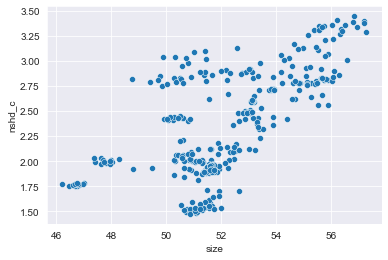

In [8]:
sns.scatterplot(data=means.reset_index(), x='size', y='nshd_c')

In [9]:
results['size'].mean(), results['size'].std()

(52.280338541666666, 3.887388511752642)

## Calculate hp importance

In [10]:
mean_rsi = means.reset_index()
mean_rsi[list(ADDITIONAL_ARGS.values()) + ['nshd_c']].corr()

,LAMBDA,NOISE_TEMPERATURE,h_LR,h_NULL,nshd_c
LAMBDA,1.000000e+00,-2.754981e-16,-5.855600e-17,1.737062e-16,-0.058489
NOISE_TEMPERATURE,-2.754981e-16,1.000000e+00,-2.373892e-17,2.883794e-17,-0.097355
h_LR,-5.855600e-17,-2.373892e-17,1.000000e+00,2.650546e-18,0.079146
h_NULL,1.737062e-16,2.883794e-17,2.650546e-18,1.000000e+00,0.310757
nshd_c,-5.848935e-02,-9.735482e-02,7.914618e-02,3.107572e-01,1.000000


In [11]:
mean_rsi.corr()

,LAMBDA,NOISE_TEMPERATURE,h_LR,h_NULL,nshd_c,tpr_c,size
LAMBDA,1.000000e+00,-2.754981e-16,-5.855600e-17,1.737062e-16,-0.058489,0.024989,-0.041321
NOISE_TEMPERATURE,-2.754981e-16,1.000000e+00,-2.373892e-17,2.883794e-17,-0.097355,0.169852,0.043095
h_LR,-5.855600e-17,-2.373892e-17,1.000000e+00,2.650546e-18,0.079146,-0.142426,-0.068234
h_NULL,1.737062e-16,2.883794e-17,2.650546e-18,1.000000e+00,0.310757,-0.285832,0.381896
nshd_c,-5.848935e-02,-9.735482e-02,7.914618e-02,3.107572e-01,1.000000,-0.989621,0.661153
tpr_c,2.498922e-02,1.698520e-01,-1.424262e-01,-2.858322e-01,-0.989621,1.000000,-0.608205
size,-4.132080e-02,4.309524e-02,-6.823356e-02,3.818961e-01,0.661153,-0.608205,1.000000


## Sensitivity

<AxesSubplot:xlabel='log(LAMBDA * NOISE_TEMPERATURE)', ylabel='nshd_c'>

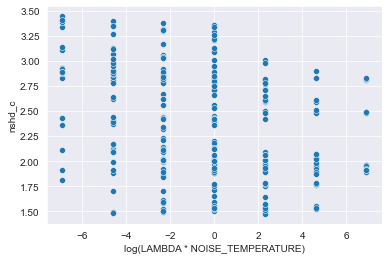

In [12]:
mean_rsi['LT'] = (mean_rsi['LAMBDA'] * mean_rsi['NOISE_TEMPERATURE'])
mean_rsi['log(LAMBDA * NOISE_TEMPERATURE)'] = mean_rsi['LT'].apply(math.log)
sns.scatterplot(data=mean_rsi, x='log(LAMBDA * NOISE_TEMPERATURE)', y='nshd_c')

<AxesSubplot:xlabel='log(LAMBDA * NOISE_TEMPERATURE)', ylabel='prec_c'>

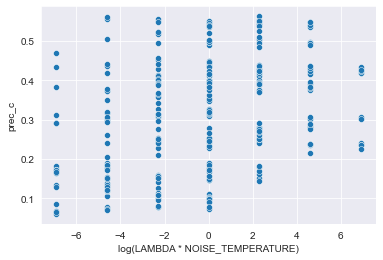

In [15]:
mean_rsi = mean_rsi.rename(columns={'tpr_c': 'prec_c'})  # Correct naming
sns.scatterplot(data=mean_rsi, x='log(LAMBDA * NOISE_TEMPERATURE)', y='prec_c')